In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import timeit
import datetime
import time
import pprint
import itertools
import pickle
import sklearn
import dask
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
import fastparquet
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import h5py
import dask
import dask.dataframe as dd
import dask.array as da
# Percentiles
from scipy.stats import percentileofscore
from IPython.display import display

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Use inventor mobility patent pairs
From: 
- https://sfengc7.stern.nyu.edu:8888/notebooks/patentdiffusion/201808Results/StrategicNonCitations/1-InventorMobilityPatents-v2.ipynb
- https://sfengc7.stern.nyu.edu:8888/notebooks/patentdiffusion/201808Results/StrategicNonCitations/1b-InventorMobilityAnalysis.ipynb
- https://sfengc7.stern.nyu.edu:8888/notebooks/patentdiffusion/201808Results/JTHReplication/1-ReplicationSample.ipynb

1. Find number of non-self citations overall for *tp, op*
2. Find number of common citations for *tp, op*
3. Find number of local citations for *tp, op*
4. Find number of total common local citations for *tp, op*

In [52]:
# mdc = fastparquet.ParquetFile("DataStore/2018-07-P2/inv_move_pat_pairs_0714.parq").to_pandas()
# print(len(mdc))
# mdc = mdc.loc[mdc["sim_docvecs"].notnull() & mdc["sim_ldavecs"].notnull()]
# print(len(mdc))

# Add target MSA
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq")\
.to_pandas(["patent", "inv_msa", "appyear"])
mdc["tp_inv_msa"] = mdc["tp"].map(dict(zip(pdf["patent"], pdf["inv_msa"])))
mdc["op_inv_msa"] = mdc["op"].map(dict(zip(pdf["patent"], pdf["inv_msa"])))
mdc["tp_appyear"] = mdc["tp"].map(dict(zip(pdf["patent"], pdf["appyear"])))
mdc["op_appyear"] = mdc["op"].map(dict(zip(pdf["patent"], pdf["appyear"])))

# Add location change
mdc["msa_change"] = ~(mdc["tp_inv_msa"] == mdc["op_inv_msa"])
del(pdf)

### 1. Number of total non-self cites

In [7]:
# Assignee of each patent
asgs = pickle.load(open("RawData/Cleaned/patent_assignee_dict_0628.pkl", "rb"))

In [9]:
cit = dd.read_parquet("RawData/Cleaned/cit_0628.parq")

%time c2 = cit[cit["citing"].isin(mdc["tp"]) | cit["citing"].isin(mdc["op"])].compute()

# Remove self-citations
%time asg_match = (set(asgs.get(cited, [])).intersection(asgs.get(citing, [])) for cited, citing \
                   in zip(c2["cited"], c2["citing"]))
%time asg_match = [len(i) for i in asg_match]
c2["asg_match"] = asg_match
c2 = c2.loc[c2["asg_match"] == 0]
c2 = c2[["citing", "cited"]]
print(len(c2))

# Copy self-citations
c2_c = c2.copy()

# Number of common citations after self-citation removal
# Dictionary of citing: cited patents
%time c2 = {n:g["cited"].tolist() for n,g in c2.groupby("citing")}

# Total number of cites
mdc["tp_num_cites"] = [len(c2.get(p, [])) for p in mdc["tp"]]
mdc["op_num_cites"] = [len(c2.get(p, [])) for p in mdc["op"]]

# Get number of overlapping
%time num_common_cites = (set(c2.get(tp, [])).intersection(set(c2.get(op, []))) for tp, op in zip(mdc["tp"], mdc["op"]))
%time mdc["num_common_cites"] = [len(i) for i in num_common_cites]
del(cit) 

CPU times: user 4min 13s, sys: 51.4 s, total: 5min 5s
Wall time: 1min 54s
CPU times: user 145 ms, sys: 82.1 ms, total: 228 ms
Wall time: 215 ms
CPU times: user 6.26 s, sys: 16.4 ms, total: 6.27 s
Wall time: 5.97 s
1222413
CPU times: user 15.6 s, sys: 472 ms, total: 16 s
Wall time: 14.9 s
CPU times: user 61.9 ms, sys: 16.9 ms, total: 78.8 ms
Wall time: 75.1 ms
CPU times: user 3.64 s, sys: 0 ns, total: 3.64 s
Wall time: 3.46 s


### 2. Number of total local citations for each patent, and number of overlapping local patents

In [10]:
c2 = c2_c.copy()
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq")\
.to_pandas(["patent", "inv_msa"])

# Get MSA of cited patent
c2["cited_inv_msa"] = c2["cited"].map(dict(zip(pdf["patent"], pdf["inv_msa"])))
c2["citing_inv_msa"] = c2["citing"].map(dict(zip(pdf["patent"], pdf["inv_msa"])))

# Get assignee of cited patent
asgs = pickle.load(open("RawData/Cleaned/patent_assignee_dict_0628.pkl", "rb"))
c2["cited_assignee"] = c2["cited"].map(asgs)
c2["citing_assignee"] = c2["citing"].map(asgs)

# Assignee and location of the target patent

c2["tp"] = c2["citing"].map(dict(zip(mdc["op"], mdc["tp"])))
c2["tp_assignee"] = c2["tp"].map(asgs)
c2["tp_inv_msa"] = c2["tp"].map(dict(zip(pdf["patent"], pdf["inv_msa"])))
del(asgs)

In [11]:
# Citations: same as TP MSA
# Count the number of citations that overlap
%time c3 = {n:g["cited"].tolist() for n,g in c2.loc[(c2["cited_inv_msa"] == c2["tp_inv_msa"])].groupby("citing")}

# Total number of local cites
mdc["tp_num_inv_msa_cites"] = [len(c3.get(p, [])) for p in mdc["tp"]]
mdc["op_num_inv_msa_cites"] = [len(c3.get(p, [])) for p in mdc["op"]]

# Get number of overlapping
%time num_common_cites = (set(c3.get(tp, [])).intersection(set(c3.get(op, []))) for tp, op in zip(mdc["tp"], mdc["op"]))
%time mdc["ncc_tp_inv_msa"] = [len(i) for i in num_common_cites]

# Citations: not TP MSA nor Citing MSA
# Count the number of citations that overlap
%time c4 = {n:g["cited"].tolist() for n,g in c2.loc[(c2["cited_inv_msa"] != c2["tp_inv_msa"])\
                                                   & (c2["cited_inv_msa"] != c2["citing_inv_msa"])].groupby("citing")}
# Get number of overlapping
%time num_common_cites = (set(c4.get(tp, [])).intersection(set(c4.get(op, []))) for tp, op in zip(mdc["tp"], mdc["op"]))
%time mdc["ncc_other_msa"] = [len(i) for i in num_common_cites]


CPU times: user 9.83 s, sys: 352 ms, total: 10.2 s
Wall time: 9.9 s
CPU times: user 60.9 ms, sys: 0 ns, total: 60.9 ms
Wall time: 59.8 ms
CPU times: user 1.45 s, sys: 0 ns, total: 1.45 s
Wall time: 1.43 s
CPU times: user 21.1 s, sys: 0 ns, total: 21.1 s
Wall time: 20.8 s
CPU times: user 27.3 ms, sys: 0 ns, total: 27.3 ms
Wall time: 26.8 ms
CPU times: user 3.35 s, sys: 0 ns, total: 3.35 s
Wall time: 3.31 s


In [12]:
mdc.head()

,op,tp,inventor_id,tp_asg,op_asg,asg_match,op_cites_tp,sim_ldavecs,sim_docvecs,tp_inv_msa,op_inv_msa,msa_change,tp_num_cites,op_num_cites,num_common_cites,tp_num_inv_msa_cites,op_num_inv_msa_cites,ncc_tp_inv_msa,ncc_other_msa
index,,,,,,,,,,,,,,,,,,,
0,3930283,3930282,3930282-1,6d92f55ba3875e01b5554b98c65c929a,6d92f55ba3875e01b5554b98c65c929a,True,False,0.546727,0.519405,"Lancaster, PA","Lancaster, PA",False,8,10,3,0,0,0,3
1,4041572,3930283,3930282-1,6d92f55ba3875e01b5554b98c65c929a,6d92f55ba3875e01b5554b98c65c929a,True,False,0.378731,0.250033,"Lancaster, PA","Lancaster, PA",False,10,6,0,0,0,0,0
2,4016624,3930283,3930282-1,6d92f55ba3875e01b5554b98c65c929a,6d92f55ba3875e01b5554b98c65c929a,True,False,0.410078,0.497906,"Lancaster, PA","Lancaster, PA",False,10,7,0,0,0,0,0
3,4102014,3930283,3930282-1,6d92f55ba3875e01b5554b98c65c929a,6d92f55ba3875e01b5554b98c65c929a,True,True,0.678831,0.264625,"Lancaster, PA","Lancaster, PA",False,10,4,0,0,0,0,0
4,4477942,3930283,3930282-1,6d92f55ba3875e01b5554b98c65c929a,6d92f55ba3875e01b5554b98c65c929a,True,False,0.566891,0.438904,"Lancaster, PA","Lancaster, PA",False,10,4,0,0,0,0,0


In [13]:
# Percentage of local cites
mdc["tp_pct_inv_msa_cites"] = mdc["tp_num_inv_msa_cites"]/mdc["tp_num_cites"]
mdc["op_pct_inv_msa_cites"] = mdc["op_num_inv_msa_cites"]/mdc["op_num_cites"]

In [18]:
del(c2_c, c2, c3, c4)

In [53]:
fastparquet.write("DataStore/2018-08/inv_mob_local_cite_sim_0904.parq", mdc, compression="GZIP")

### Add mobility data and select subset
1. Only want to compare first to second firm (*tp_asg_rank* <= 1)
2. Only want those who changed firms (*asg_match* == False)
3. Prior to the change, only want to compare inventors' own inventions to same firm, same MSA

In [41]:
c_dict = pickle.load(open("DataStore/2018-06/col_names_dict.pkl", "rb"))
ip = pd.read_pickle("DataStore/2018-07/inv_move_pats_0712.pkl")
ip = dict(zip(ip["patent"], ip["inv_asg_rank"]))
mdc = fastparquet.ParquetFile("DataStore/2018-08/inv_mob_local_cite_sim_0904.parq").to_pandas()
mdc["tp_asg_rank"] = mdc["tp"].map(ip)
mdc["op_asg_rank"] = mdc["op"].map(ip)

#TP Pct of Common Cites
mdc["tp_pct_common_cites"] = mdc["num_common_cites"]/mdc["tp_num_cites"]

# Primary class match
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas(["patent", "primclass"])
mdc["tp_primclass"] = mdc["tp"].map(dict(zip(pdf["patent"], pdf["primclass"])))
mdc["op_primclass"] = mdc["op"].map(dict(zip(pdf["patent"], pdf["primclass"])))
mdc["primclass_match"] = (mdc["tp_primclass"] == mdc["op_primclass"])

# Bins
import math

def sim_bin(x, a):
    try:
        return round(round(x / a) * a, -int(math.floor(math.log10(a))))
    except:
        return np.nan
    
mdc["bin_sim_ldavecs"] = mdc["sim_ldavecs"].apply(lambda x: sim_bin(x, 0.1))
mdc["bin_sim_docvecs"] = mdc["sim_docvecs"].apply(lambda x: sim_bin(x, 0.1))

# Year group
def get_year_group_10(x):
    if x in range(1975,1985):
        yg = "1975-85"
    elif x in range(1985,1995):
        yg = "1985-95"
    elif x in range(1995, 2005):
        yg = "1995-05"
    elif x in range(2005,2015):
        yg = "2005-15"
    else:
        yg = np.nan
    return yg

mdc["year_group"] = mdc["tp_appyear"].apply(get_year_group_10)

In [54]:
# Only want to compare first to first, and first to second firm: same as 1b
print(len(mdc))
i2 = mdc.loc[((mdc["tp_asg_rank"] == 0) & (mdc["op_asg_rank"] == 0)) |
                       ((mdc["tp_asg_rank"] == 0) & (mdc["op_asg_rank"] == 1))].copy()
print(len(i2))

# Firm change
i2["firm_change"] = i2["op_asg_rank"].apply(lambda x: "Before" if x == 0 else "After")

# Trim outliers
i2 = i2.loc[i2["num_common_cites"] <= np.percentile(i2["num_common_cites"], 99)]
print(len(i2))

# Put together highest in bin
i2.loc[i2["bin_sim_docvecs"] >= 0.7, "bin_sim_docvecs"] = 0.7
# Put together in lowest bin
i2.loc[i2["bin_sim_docvecs"] <= -0.1, "bin_sim_docvecs"] = -0.1
print(len(i2))

# Group averages
i2_c = i2.copy()

571068
329575
326309
326309


In [25]:
i2["year_group"].value_counts()

1995-05    112901
1985-95     82981
1975-85     61411
2005-15     39189
Name: year_group, dtype: int64

In [6]:
i2.columns

Index(['op', 'tp', 'inventor_id', 'tp_asg', 'op_asg', 'asg_match',
       'op_cites_tp', 'sim_ldavecs', 'sim_docvecs', 'tp_inv_msa', 'op_inv_msa',
       'msa_change', 'tp_num_cites', 'op_num_cites', 'num_common_cites',
       'tp_num_inv_msa_cites', 'op_num_inv_msa_cites', 'ncc_tp_inv_msa',
       'ncc_other_msa', 'tp_pct_inv_msa_cites', 'op_pct_inv_msa_cites',
       'tp_asg_rank', 'op_asg_rank', 'bin_sim_ldavecs', 'bin_sim_docvecs',
       'tp_appyear', 'op_appyear', 'year_group', 'firm_change'],
      dtype='object')

In [71]:
r

,num_common_cites
0,1.13101
1,0.793346
2,[6.4944451453379115e-18]
3,0.95518
4,[0.00041836535094717813]
5,0.49846
6,[6.715313530812286e-48]


In [81]:
res = {}
for yg in ["1985-95", "1995-05", "2005-15", "all"]:
    if yg == "all":
        i2 = i2_c
    else:
        i2 = i2_c.loc[(i2_c["year_group"] == yg)]
    r = pd.DataFrame()
    for c in ["num_common_cites", "tp_pct_common_cites", "ncc_tp_inv_msa", "tp_pct_inv_msa_cites", "sim_docvecs", "primclass_match"]:
        r[c] = [i2.loc[(i2["firm_change"] == "Before"), [c]].mean()[0],
#                 i2.loc[(i2["firm_change"] == "Before"), [c]].std()[0],
                i2.loc[(i2["firm_change"] == "After"), [c]].mean()[0],
#                 i2.loc[(i2["firm_change"] == "After"), [c]].std()[0],
                sp.stats.ttest_ind(i2.loc[(i2["firm_change"] == "Before"), c],
                                  i2.loc[(i2["firm_change"] == "After"), c],
                                  equal_var=False, nan_policy="omit")[1],
                i2.loc[(i2["firm_change"] == "After") & (i2["msa_change"] == False), [c]].mean()[0],
#                 i2.loc[(i2["firm_change"] == "After") & (i2["msa_change"] == False), [c]].std()[0],
                sp.stats.ttest_ind(i2.loc[(i2["firm_change"] == "Before"), c],
                                  i2.loc[(i2["firm_change"] == "After") & (i2["msa_change"] == False), c],
                                  equal_var=False, nan_policy="omit")[1],
                i2.loc[(i2["firm_change"] == "After") & (i2["msa_change"] == True), [c]].mean()[0],
#                 i2.loc[(i2["firm_change"] == "After") & (i2["msa_change"] == True), [c]].std()[0],
                sp.stats.ttest_ind(i2.loc[(i2["firm_change"] == "Before"), c],
                                  i2.loc[(i2["firm_change"] == "After") & (i2["msa_change"] == True), c],
                                  equal_var=False, nan_policy="omit")[1],
               ]
#     r["vals"] = ["Before Firm Change, Mean","Before Firm Change, SD", "After Firm Change, Mean", 
#                  "After Firm Change, SD","After Firm Change - Same MSA, Mean", "After Firm Change - Same MSA, SD",
#                 "After Firm Change - Diff MSA, Mean", "After Firm Change - Diff MSA, SD"]
        r["vals"] = ["Before Firm Change, Mean","After Firm Change, Mean", "$p$-value",
                 "After Firm Change - Same MSA, Mean", "$p$-value",
                "After Firm Change - Diff MSA, Mean", "$p$-value"]
    r = r.set_index('vals')
    r.index.name = None
    r.columns = ["Num Common Cited", "Pct Common Cited", "\thead{Num Common Cited\\\\from Prev MSA}",
                 "\thead{Pct Common Cited\\\\from Prev MSA", "Sim DocVecs", "Primclass Match"]
    res[yg] = r

In [82]:
for k,v in res.items():
    print(k)
    display(np.round(v,2))
    print(np.round(v,2).to_latex(escape=False, column_format="lcccccc"))

1985-95


,Num Common Cited,Pct Common Cited,head{Num Common Cited\\from Prev MSA},head{Pct Common Cited\\from Prev MSA,Sim DocVecs,Primclass Match
"Before Firm Change, Mean",1.13,0.07,0.04,0.03,0.26,0.33
"After Firm Change, Mean",0.79,0.04,0.01,0.02,0.24,0.34
$p$-value,0.00,0.00,0.00,0.00,0.00,0.05
"After Firm Change - Same MSA, Mean",0.96,0.05,0.02,0.03,0.25,0.32
$p$-value,0.00,0.00,0.00,0.00,0.00,0.00
"After Firm Change - Diff MSA, Mean",0.50,0.03,0.01,0.01,0.23,0.38
$p$-value,0.00,0.00,0.00,0.00,0.00,0.00


\begin{tabular}{lcccccc}
\toprule
{} &  Num Common Cited &  Pct Common Cited &  \thead{Num Common Cited\\from Prev MSA} &  \thead{Pct Common Cited\\from Prev MSA &  Sim DocVecs &  Primclass Match \\
\midrule
Before Firm Change, Mean           &              1.13 &              0.07 &                                     0.04 &                                    0.03 &         0.26 &             0.33 \\
After Firm Change, Mean            &              0.79 &              0.04 &                                     0.01 &                                    0.02 &         0.24 &             0.34 \\
$p$-value                          &              0.00 &              0.00 &                                     0.00 &                                    0.00 &         0.00 &             0.05 \\
After Firm Change - Same MSA, Mean &              0.96 &              0.05 &                                     0.02 &                                    0.03 &         0.25 &             0.32 \\
$p$-

,Num Common Cited,Pct Common Cited,head{Num Common Cited\\from Prev MSA},head{Pct Common Cited\\from Prev MSA,Sim DocVecs,Primclass Match
"Before Firm Change, Mean",34.77,0.21,1.92,0.06,0.31,0.41
"After Firm Change, Mean",3.58,0.10,0.11,0.03,0.24,0.31
$p$-value,0.00,0.00,0.00,0.00,0.00,0.00
"After Firm Change - Same MSA, Mean",4.16,0.13,0.17,0.03,0.27,0.35
$p$-value,0.00,0.00,0.00,0.00,0.00,0.00
"After Firm Change - Diff MSA, Mean",2.65,0.05,0.03,0.03,0.20,0.25
$p$-value,0.00,0.00,0.00,0.00,0.00,0.00


\begin{tabular}{lcccccc}
\toprule
{} &  Num Common Cited &  Pct Common Cited &  \thead{Num Common Cited\\from Prev MSA} &  \thead{Pct Common Cited\\from Prev MSA &  Sim DocVecs &  Primclass Match \\
\midrule
Before Firm Change, Mean           &             34.77 &              0.21 &                                     1.92 &                                    0.06 &         0.31 &             0.41 \\
After Firm Change, Mean            &              3.58 &              0.10 &                                     0.11 &                                    0.03 &         0.24 &             0.31 \\
$p$-value                          &              0.00 &              0.00 &                                     0.00 &                                    0.00 &         0.00 &             0.00 \\
After Firm Change - Same MSA, Mean &              4.16 &              0.13 &                                     0.17 &                                    0.03 &         0.27 &             0.35 \\
$p$-

,Num Common Cited,Pct Common Cited,head{Num Common Cited\\from Prev MSA},head{Pct Common Cited\\from Prev MSA,Sim DocVecs,Primclass Match
"Before Firm Change, Mean",10.59,0.15,1.02,0.09,0.30,0.34
"After Firm Change, Mean",2.05,0.04,0.07,0.02,0.28,0.29
$p$-value,0.00,0.00,0.00,0.00,0.00,0.00
"After Firm Change - Same MSA, Mean",2.47,0.05,0.09,0.03,0.29,0.30
$p$-value,0.00,0.00,0.00,0.00,0.00,0.00
"After Firm Change - Diff MSA, Mean",0.92,0.02,0.01,0.01,0.26,0.25
$p$-value,0.00,0.00,0.00,0.00,0.00,0.00


\begin{tabular}{lcccccc}
\toprule
{} &  Num Common Cited &  Pct Common Cited &  \thead{Num Common Cited\\from Prev MSA} &  \thead{Pct Common Cited\\from Prev MSA &  Sim DocVecs &  Primclass Match \\
\midrule
Before Firm Change, Mean           &             10.59 &              0.15 &                                     1.02 &                                    0.09 &         0.30 &             0.34 \\
After Firm Change, Mean            &              2.05 &              0.04 &                                     0.07 &                                    0.02 &         0.28 &             0.29 \\
$p$-value                          &              0.00 &              0.00 &                                     0.00 &                                    0.00 &         0.00 &             0.00 \\
After Firm Change - Same MSA, Mean &              2.47 &              0.05 &                                     0.09 &                                    0.03 &         0.29 &             0.30 \\
$p$-

,Num Common Cited,Pct Common Cited,head{Num Common Cited\\from Prev MSA},head{Pct Common Cited\\from Prev MSA,Sim DocVecs,Primclass Match
"Before Firm Change, Mean",15.61,0.13,0.94,0.05,0.29,0.35
"After Firm Change, Mean",1.92,0.05,0.05,0.02,0.25,0.30
$p$-value,0.00,0.00,0.00,0.00,0.00,0.00
"After Firm Change - Same MSA, Mean",2.27,0.06,0.07,0.03,0.26,0.31
$p$-value,0.00,0.00,0.00,0.00,0.00,0.00
"After Firm Change - Diff MSA, Mean",1.23,0.03,0.02,0.02,0.22,0.28
$p$-value,0.00,0.00,0.00,0.00,0.00,0.00


\begin{tabular}{lcccccc}
\toprule
{} &  Num Common Cited &  Pct Common Cited &  \thead{Num Common Cited\\from Prev MSA} &  \thead{Pct Common Cited\\from Prev MSA &  Sim DocVecs &  Primclass Match \\
\midrule
Before Firm Change, Mean           &             15.61 &              0.13 &                                     0.94 &                                    0.05 &         0.29 &             0.35 \\
After Firm Change, Mean            &              1.92 &              0.05 &                                     0.05 &                                    0.02 &         0.25 &             0.30 \\
$p$-value                          &              0.00 &              0.00 &                                     0.00 &                                    0.00 &         0.00 &             0.00 \\
After Firm Change - Same MSA, Mean &              2.27 &              0.06 &                                     0.07 &                                    0.03 &         0.26 &             0.31 \\
$p$-

In [67]:
i_dict = {'firm_change_Before_count': 'Before Firm Change, $N$', 
          'firm_change_Before_pct_common_cites': 'Before Firm Change, Pct Common Cites',
       'firm_change_After_count': 'After Firm Change, $N$',
          'firm_change_After_pct_common_cites': 'After Firm Change, Pct Common Cites',
         "Diff, $p$-value": "Diff, $p$-value"}
c_dict = pickle.load(open("DataStore/2018-06/col_names_dict.pkl", "rb"))

In [68]:
tab = {}
for dm in ["bin_sim_ldavecs", "bin_sim_docvecs"]:
    summ = pd.DataFrame()
    c = "firm_change"
    c_vals = ["Before", "After"]
    k = "tp_pct_common_cites"
    mg = i2[[dm, c, k]].groupby(dm)
    pval = [sp.stats.ttest_ind(g.loc[(g[c] == c_vals[0]), k],\
                              g.loc[(g[c] == c_vals[1]), k], equal_var=False, nan_policy='omit')[1]\
           for n,g in mg]
    
    for m in c_vals:
        m2 = i2.loc[i2[c] == m]
        summ["{0}_{1}_count".format(c, str(m))] = m2.groupby([dm]).size().astype(str)
        summ["{0}_{1}_pct_common_cites".format(c, str(m))] = np.round(m2[[dm, k]].groupby(dm).mean(),3)
    
    summ = summ.rename(columns=i_dict)
    summ["Diff, $p$-value"] = np.round(pval,3)
    summ = summ.T
    summ.columns = c_dict["x_labels"][dm]
    tab[dm] = summ
tab_p = tab

In [69]:
for k,v in tab_p.items():
    print(k)
    display(v)
    print(v.to_latex())

bin_sim_ldavecs


,0.0,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0
"Before Firm Change, $N$",10352,21224,23560,24369,25545,24696,23078,21251,20011,18466,8376
"Before Firm Change, Pct Common Cites",0.041,0.054,0.078,0.082,0.095,0.117,0.134,0.157,0.206,0.24,0.333
"After Firm Change, $N$",8942,12522,12296,11784,11813,11504,11056,10104,8414,5676,1270
"After Firm Change, Pct Common Cites",0.006,0.017,0.024,0.03,0.038,0.047,0.058,0.074,0.093,0.14,0.428
"Diff, $p$-value",0,0,0,0,0,0,0,0,0,0,0


\begin{tabular}{llllllllllll}
\toprule
{} &    0.0 & 0.0-0.1 & 0.1-0.2 & 0.2-0.3 & 0.3-0.4 & 0.4-0.5 & 0.5-0.6 & 0.6-0.7 & 0.7-0.8 & 0.8-0.9 & 0.9-1.0 \\
\midrule
Before Firm Change, \$N\$              &  10352 &   21224 &   23560 &   24369 &   25545 &   24696 &   23078 &   21251 &   20011 &   18466 &    8376 \\
Before Firm Change, Pct Common Cites &  0.041 &   0.054 &   0.078 &   0.082 &   0.095 &   0.117 &   0.134 &   0.157 &   0.206 &    0.24 &   0.333 \\
After Firm Change, \$N\$               &   8942 &   12522 &   12296 &   11784 &   11813 &   11504 &   11056 &   10104 &    8414 &    5676 &    1270 \\
After Firm Change, Pct Common Cites  &  0.006 &   0.017 &   0.024 &    0.03 &   0.038 &   0.047 &   0.058 &   0.074 &   0.093 &    0.14 &   0.428 \\
Diff, \$p\$-value                      &      0 &       0 &       0 &       0 &       0 &       0 &       0 &       0 &       0 &       0 &       0 \\
\bottomrule
\end{tabular}

bin_sim_docvecs


,<0.1,-0.1-0.0,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6+
"Before Firm Change, $N$",3620,12775,32021,49163,50138,35447,18975,9756,9033
"Before Firm Change, Pct Common Cites",0.039,0.034,0.044,0.062,0.086,0.135,0.235,0.419,0.658
"After Firm Change, $N$",3205,8593,18731,24868,22734,15419,7678,2701,1452
"After Firm Change, Pct Common Cites",0.007,0.009,0.015,0.028,0.046,0.071,0.107,0.211,0.52
"Diff, $p$-value",0,0,0,0,0,0,0,0,0


\begin{tabular}{llllllllll}
\toprule
{} &   <0.1 & -0.1-0.0 & 0.0-0.1 & 0.1-0.2 & 0.2-0.3 & 0.3-0.4 & 0.4-0.5 & 0.5-0.6 &   0.6+ \\
\midrule
Before Firm Change, \$N\$              &   3620 &    12775 &   32021 &   49163 &   50138 &   35447 &   18975 &    9756 &   9033 \\
Before Firm Change, Pct Common Cites &  0.039 &    0.034 &   0.044 &   0.062 &   0.086 &   0.135 &   0.235 &   0.419 &  0.658 \\
After Firm Change, \$N\$               &   3205 &     8593 &   18731 &   24868 &   22734 &   15419 &    7678 &    2701 &   1452 \\
After Firm Change, Pct Common Cites  &  0.007 &    0.009 &   0.015 &   0.028 &   0.046 &   0.071 &   0.107 &   0.211 &   0.52 \\
Diff, \$p\$-value                      &      0 &        0 &       0 &       0 &       0 &       0 &       0 &       0 &      0 \\
\bottomrule
\end{tabular}



### Plots

In [55]:
%matplotlib inline
c_dict = pickle.load(open("DataStore/2018-06/col_names_dict.pkl", "rb"))

sns.set(font_scale=1.4)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams.update({'font.size': 20})
savepath = "DataStore/2018-07-P2/ResultsGraphs/SNC/"
def p1(x, y, hue, data, bars, order, ax): 
    g = sns.pointplot(x = x, y = y, hue = hue, 
                data = data, ci = bars, markers = ".", 
                order = order, dodge = True, errwidth = 1,
                palette = sns.color_palette("Greys_r", 3),
                n_boot = 100,      
                  ax = ax)
    sns.despine()
    return g

    
def p2(x, y, data, order, ax, conf_int = None):
    g = sns.pointplot(x=x, y=y, data = data, ci = conf_int, join = True,
                 order = order, markers = ".", color="grey", ax = ax)
    sns.despine()
    return g

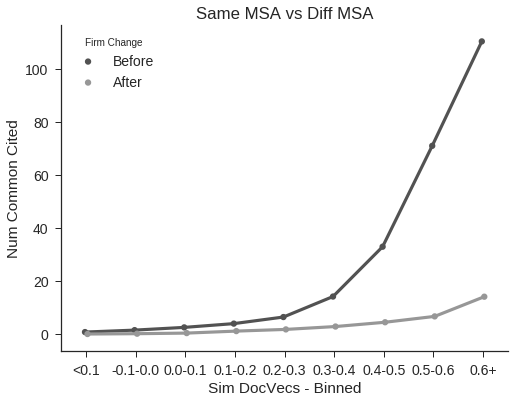

In [83]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,6))
x1 = "bin_sim_docvecs"
order1 = None
conf_int1 = None
y1 = "num_common_cites"
df = i2
hue1 = "firm_change"
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = ax)
g3.legend(loc='upper left', title = "Firm Change")
ax.set_xticklabels(c_dict["x_labels"]["bin_sim_docvecs"])
g3.set_title("Same MSA vs Diff MSA")
g3.set_ylabel(c_dict[y1])
g3.set_xlabel(c_dict[x1])
plt.savefig(savepath+"1c-NumCommonCited-DV.png")
plt.show()
del(fig,ax)

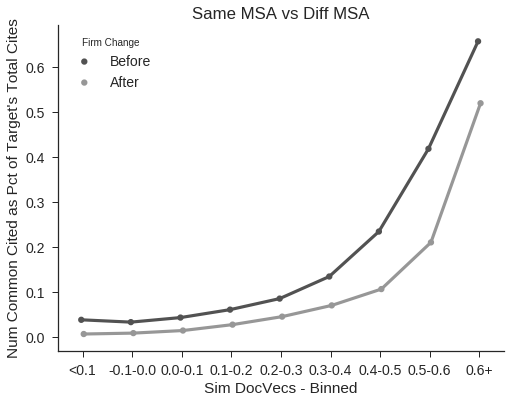

In [84]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,6))
x1 = "bin_sim_docvecs"
order1 = None
conf_int1 = None
y1 = "tp_pct_common_cites"
df = i2
hue1 = "firm_change"
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = ax)
g3.legend(loc='upper left', title = "Firm Change")
ax.set_xticklabels(c_dict["x_labels"]["bin_sim_docvecs"])
g3.set_title("Same MSA vs Diff MSA")
g3.set_ylabel(c_dict[y1])
g3.set_xlabel(c_dict[x1])
plt.savefig(savepath+"1c-PctCommonCited-DV.png")
plt.show()
del(fig,ax)